In [11]:
import os
import sys
import joblib
import numpy as np
import pandas as pd
import logging
import time
from math import log
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('default')

from itertools import product
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [17]:
def ic_scale(pwm,background):
    odds_ratio = ((pwm+0.001)/(1.004))/(background[None,:])
    ic = ((np.log((pwm+0.001)/(1.004))/np.log(2))*pwm -\
            (np.log(background)*background/np.log(2))[None,:])
    return pwm*(np.sum(ic,axis=1)[:,None])


def plot_a(ax, base, left_edge, height, color):
    a_polygon_coords = [
        np.array([
           [0.0, 0.0],
           [0.5, 1.0],
           [0.5, 0.8],
           [0.2, 0.0],
        ]),
        np.array([
           [1.0, 0.0],
           [0.5, 1.0],
           [0.5, 0.8],
           [0.8, 0.0],
        ]),
        np.array([
           [0.225, 0.45],
           [0.775, 0.45],
           [0.85, 0.3],
           [0.15, 0.3],
        ])
    ]
    for polygon_coords in a_polygon_coords:
        ax.add_patch(
            matplotlib.patches.Polygon(
                (np.array([1,height])[None,:]*polygon_coords
                 + np.array([left_edge,base])[None,:]),
                facecolor=color, edgecolor=color))


def plot_c(ax, base, left_edge, height, color):
    ax.add_patch(matplotlib.patches.Ellipse(
        xy=[left_edge+0.65, base+0.5*height], width=1.3, height=height,
        facecolor=color, edgecolor=color))
    ax.add_patch(matplotlib.patches.Ellipse(
        xy=[left_edge+0.65, base+0.5*height], width=0.7*1.3, height=0.7*height,
        facecolor='white', edgecolor='white'))
    ax.add_patch(matplotlib.patches.Rectangle(
        xy=[left_edge+1, base], width=1.0, height=height,
        facecolor='white', edgecolor='white', fill=True))


def plot_g(ax, base, left_edge, height, color):
    ax.add_patch(matplotlib.patches.Ellipse(
        xy=[left_edge+0.65, base+0.5*height], width=1.3, height=height,
        facecolor=color, edgecolor=color))
    ax.add_patch(matplotlib.patches.Ellipse(
        xy=[left_edge+0.65, base+0.5*height], width=0.7*1.3, height=0.7*height,
        facecolor='white', edgecolor='white'))
    ax.add_patch(matplotlib.patches.Rectangle(
        xy=[left_edge+1, base], width=1.0, height=height,
        facecolor='white', edgecolor='white', fill=True))
    ax.add_patch(matplotlib.patches.Rectangle(
        xy=[left_edge+0.825, base+0.085*height],
        width=0.174, height=0.415*height,
        facecolor=color, edgecolor=color, fill=True))
    ax.add_patch(matplotlib.patches.Rectangle(
        xy=[left_edge+0.625, base+0.35*height],
        width=0.374, height=0.15*height,
        facecolor=color, edgecolor=color, fill=True))


def plot_t(ax, base, left_edge, height, color):
    ax.add_patch(
        matplotlib.patches.Rectangle(xy=[left_edge+0.4, base],
        width=0.2, height=height, facecolor=color, edgecolor=color, fill=True))
    ax.add_patch(
        matplotlib.patches.Rectangle(xy=[left_edge, base+0.8*height],
        width=1.0, height=0.2*height, facecolor=color,
        edgecolor=color, fill=True))

    
def plot_u(ax, base, left_edge, height, color):
    ax.add_patch(matplotlib.patches.Ellipse(
        xy=[left_edge+0.5, base+0.4*height], width=0.95, height=0.8*height,
        facecolor=color, edgecolor=color))
    ax.add_patch(matplotlib.patches.Rectangle(
        xy=[left_edge+0.025, base+0.4*height], width=0.95, height=0.6*height,
        facecolor=color, edgecolor=color, fill=True))
    ax.add_patch(matplotlib.patches.Ellipse(
        xy=[left_edge+0.5, base+0.4*height], width=0.6175, height=0.52*height,
        facecolor='white', edgecolor='white'))
    ax.add_patch(matplotlib.patches.Rectangle(
        xy=[left_edge+0.19125, base+0.4*height], width=0.6175, height=0.6*height,
        facecolor='white', edgecolor='white', fill=True))

    
default_colors = {0:'red', 1:'blue', 2:'orange', 3:'green'}
dna_plot_funcs = {0:plot_a, 1:plot_c, 2:plot_g, 3:plot_t}
rna_plot_funcs = {0:plot_a, 1:plot_c, 2:plot_g, 3:plot_u}


def plot_weights_given_ax(ax, array,          
                 height_padding_factor=0.2,
                 length_padding=1.0,
                 subticks_frequency="auto",
                 colors=default_colors,
                 plot_funcs=dna_plot_funcs,
                 highlight={},
                 ylabel=""):
    if len(array.shape)==3:
        array = np.squeeze(array)
    assert len(array.shape)==2, array.shape
    if (array.shape[0]==4 and array.shape[1] != 4):
        array = array.transpose(1,0)
    assert array.shape[1]==4
    if (subticks_frequency=="auto"):
        subticks_frequency = 1.0 if len(array) <= 40 else int(len(array)/40)
    max_pos_height = 0.0
    min_neg_height = 0.0
    heights_at_positions = []
    depths_at_positions = []
    for i in range(array.shape[0]):
        #sort from smallest to highest magnitude
        acgt_vals = sorted(enumerate(array[i,:]), key=lambda x: abs(x[1]))
        positive_height_so_far = 0.0
        negative_height_so_far = 0.0
        for letter in acgt_vals:
            plot_func = plot_funcs[letter[0]]
            color=colors[letter[0]]
            if (letter[1] > 0):
                height_so_far = positive_height_so_far
                positive_height_so_far += letter[1]                
            else:
                height_so_far = negative_height_so_far
                negative_height_so_far += letter[1]
            plot_func(ax=ax, base=height_so_far,
                      left_edge=i+0.5, height=letter[1], color=color)
        max_pos_height = max(max_pos_height, positive_height_so_far)
        min_neg_height = min(min_neg_height, negative_height_so_far)
        heights_at_positions.append(positive_height_so_far)
        depths_at_positions.append(negative_height_so_far)

    #now highlight any desired positions; the key of
    #the highlight dict should be the color
    for color in highlight:
        for start_pos, end_pos in highlight[color]:
            assert start_pos >= 0.0 and end_pos <= array.shape[0]
            min_depth = np.min(depths_at_positions[start_pos:end_pos])
            max_height = np.max(heights_at_positions[start_pos:end_pos])
            ax.add_patch(
                matplotlib.patches.Rectangle(xy=[start_pos,min_depth],
                    width=end_pos-start_pos,
                    height=max_height-min_depth,
                    edgecolor=color, fill=False))
            
    ax.set_xlim(0.5-length_padding, 0.5+array.shape[0]+length_padding)
    ax.xaxis.set_ticks(np.arange(1.0, array.shape[0]+1, subticks_frequency))
    height_padding = max(abs(min_neg_height)*(height_padding_factor),
                         abs(max_pos_height)*(height_padding_factor))
    ax.set_ylim(min_neg_height-height_padding, max_pos_height+height_padding)
    ax.set_ylabel(ylabel)
    ax.yaxis.label.set_fontsize(15)


def plot_weights(array,
                 figsize=(20,2),
                 ax_transform_func=lambda x: x,
                 **kwargs):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111) 
    ax_transform_func(ax)
    plot_weights_given_ax(ax=ax,
        array=array,
        **kwargs)
    plt.show()
    
    
def save_plot_weights(array,
                 figsize=(20,2),
                 ax_transform_func=lambda x: x,
                      idx=0,
                 **kwargs):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111) 
    ax_transform_func(ax)
    plot_weights_given_ax(ax=ax,
        array=array,
        **kwargs)
    plt.show()
    fig.savefig("occlusion_bok_TF{}.pdf".format(idx), bbox_inches='tight')
    
    
def dna_plot_weights(array, **kwargs):
    plot_weights(array=array, plot_funcs=dna_plot_funcs, **kwargs)
    
def save_dna_plot_weights(array, idx=0, **kwargs):
    save_plot_weights(array=array, idx=idx, plot_funcs=dna_plot_funcs, **kwargs)

def rna_plot_weights(array, **kwargs):
    plot_weights(array=array, plot_funcs=rna_plot_funcs, **kwargs)

In [22]:
def one_hot_encode_along_channel_axis(sequence, scores):
    to_return = np.zeros((len(sequence),4), dtype=np.float)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, scores=scores, one_hot_axis=1)
    return to_return


def seq_to_one_hot_fill_in_array(zeros_array, sequence, scores, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            if scores[i] > 0:
                zeros_array[char_idx,i] = scores[i]
        elif (one_hot_axis==1):
            if scores[i] > 0: 
                zeros_array[i,char_idx] = scores[i]

In [8]:
def createKmerSet(kmersize):
    '''
    write all possible kmers
    :param kmersize: integer, 8
    :return uniq_kmers: list of sorted unique kmers
    '''
    kmerSet = set()
    nucleotides = ["a", "c", "g", "t"]    
    kmerall = product(nucleotides, repeat=kmersize)
    for i in kmerall:
        kmer = ''.join(i)
        kmerSet.add(kmer)
    uniq_kmers = sorted(list(kmerSet))  
    return uniq_kmers


def compute_kmer_entropy(kmer):
    '''
    compute shannon entropy for each kmer
    :param kmer: string
    :return entropy: float
    '''
    prob = [float(kmer.count(c)) / len(kmer) for c in dict.fromkeys(list(kmer))]
    entropy = - sum([ p * log(p) / log(2.0) for p in prob ])
    return round(entropy, 2)


def make_stopwords(kmersize):
    '''
    write filtered out kmers
    :param kmersize: integer, 8
    :return stopwords: list of sorted low-complexity kmers
    '''
    kmersize_filter = {5:1.3, 6:1.3, 7:1.3, 8:1.3, 9:1.3, 10:1.3}
    limit_entropy = kmersize_filter.get(kmersize)
    kmerSet = set()
    nucleotides = ["a", "c", "g", "t"]    
    kmerall = product(nucleotides, repeat=kmersize)
    for n in kmerall:
        kmer = ''.join(n)
        
        if compute_kmer_entropy(kmer) < limit_entropy:
            kmerSet.add(make_newtoken(kmer))
        else:
            continue
    stopwords = sorted(list(kmerSet))
    return stopwords

  
def createNewtokenSet(kmersize):
    '''
    write all possible newtokens
    :param kmersize: integer, 8
    :return uniq_newtokens: list of sorted unique newtokens
    ''' 
    newtokenSet = set()
    uniq_kmers = createKmerSet(kmersize)
    for kmer in uniq_kmers:
        newtoken = make_newtoken(kmer)
        newtokenSet.add(newtoken)  
    uniq_newtokens = sorted(list(newtokenSet))
    return uniq_newtokens      


def make_newtoken(kmer):
    '''
    write a collapsed kmer and kmer reverse complementary as a newtoken
    :param kmer: string e.g., "AT"
    :return newtoken: string e.g., "atnta"
    :param kmer: string e.g., "TA"
    :return newtoken: string e.g., "atnta"
    '''
    kmer = str(kmer).lower()
    newtoken = "n".join(sorted([kmer,kmer.translate(str.maketrans('tagc', 'atcg'))[::-1]]))
    return newtoken

def write_ngrams(sequence):
    '''
    write a bag of newtokens of size n
    :param sequence: string e.g., "ATCG"
    :param (intern) kmerlength e.g., 2
    :return newtoken_string: string e.g., "atnta" "gatc" "cgcg" 
    '''
    seq = str(sequence).lower()
    finalstart = (len(seq)-kmerlength)+1
    allkmers = [seq[start:(start+kmerlength)] for start in range(0,finalstart)]
    tokens = [make_newtoken(kmer) for kmer in allkmers if len(kmer) == kmerlength and "n" not in kmer]
    newtoken_string = " ".join(tokens)
    return newtoken_string

def tokenize_fasta(file_name, label):
    #print("Parsing fasta file... fasta headers will be retained")
    fasta_seqs = [x.rstrip() for (i,x) in enumerate(open(file_name))
              if i%2==1]
    fasta_idx = [x.rstrip().replace(">", "") for (i,x) in enumerate(open(file_name))
              if i%2!=1]
    df_sequences = pd.DataFrame(fasta_seqs, columns =['dna_string']) 
    df_sequences['idx_seq'] = fasta_idx
    #print("Collecting tokens")
    df_sequences["tokens"] = df_sequences["dna_string"].apply(write_ngrams)
    df_sequences["bound"] = label
    return df_sequences["tokens"].tolist(), df_sequences["bound"].tolist(), df_sequences["idx_seq"].tolist()

    
def build_vocabulary(all_tokens, stpwrds):
    tmpvectorizer = TfidfVectorizer(min_df = 1 , max_df = 1.0, sublinear_tf=True,use_idf=True)
    X_TFIDF_ALL =  tmpvectorizer.fit_transform(all_tokens) #newtoken sequences to numeric index.
    vcblry = tmpvectorizer.get_feature_names()
    kmer_names = [x for x in vcblry if x not in stpwrds]
    feature_names = np.asarray(kmer_names) #key transformation to use the fancy index into the report
        
    #Check that tokens are as many as expected math.pow(4, kmerlength)/2
    if len(kmer_names) > expected_tokens:
        print("ERROR: Expected %d tokens. Obtained %d tokens" % (expected_tokens, len(kmer_names)))
        logging.info("Expecting %d tokens" % expected_tokens)
        logging.info("Feature index contains %d tokens" % len(kmer_names))
        logging.info("ERROR: expected %d tokens, got %d tokens" % (expected_tokens, len(kmer_names)))
        logging.info("ERROR: More features than expected!")
        quit()
    else:
        logging.info("Feature index contains %d tokens" % len(kmer_names))

    return kmer_names, feature_names

def mutated_sequence(input_sequence, pos):
    original = list(input_sequence)
    original[pos] = 'N'
    return "".join(original)

In [9]:
family_name = "test"
kmersize = 7
filtered = True
mode = "mode_filtered"
kmerlength = int(kmersize)
newtoken_size = 1+(kmerlength*2)
all_tokens = createNewtokenSet(kmerlength)
expected_tokens = len(all_tokens)
stpwrds = make_stopwords(kmerlength)

run_id = str(int(time.time()))
file_name = 'kgrammar_bag-of-k-mers_model_' + run_id +'_' + family_name +'_'+str(kmerlength)+'_'+mode+'.txt'
logging.basicConfig(level=logging.INFO, filename=file_name, filemode="a+",
                        format="%(asctime)-15s %(levelname)-8s %(message)s")
logging.info("kmer_grammar_bag-of-k-mers RUN ID")
logging.info(run_id)
logging.info("input: kmerlength")
logging.info(str(kmersize))
logging.info("input: family")
logging.info(str(family_name))
logging.info("input: filtered")
logging.info(filtered)

print('-' * 80)
print("Kgrammar run id: ", run_id)
print("family %s k-size %d -filtered %s" % (family_name, kmerlength, str(filtered)))

--------------------------------------------------------------------------------
Kgrammar run id:  1569589922
family test k-size 7 -filtered True


/Users/mm2842/Box/p_TFs_maize_Aug_06_2019/bok_models/GLK_ZmTF5.bagkmer.k7.1550802193.0/model/GLK_ZmTF5.bagkmer.k7.1550802193.0.3.pkl


//anaconda/lib/python3.5/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.1 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


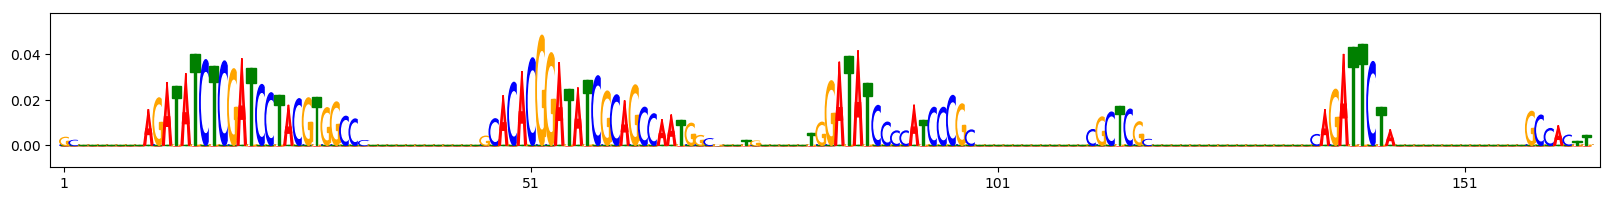

/Users/mm2842/Box/p_TFs_maize_Aug_06_2019/bok_models/GLK_ZmTF172.bagkmer.k7.1550802137.0/model/GLK_ZmTF172.bagkmer.k7.1550802137.0.2.pkl


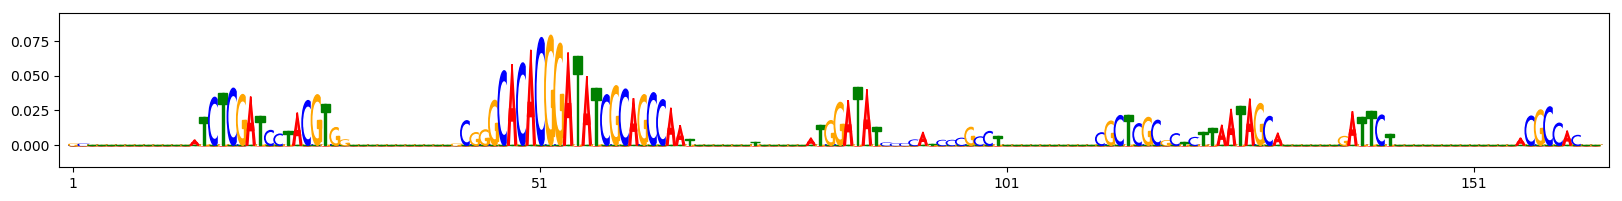

/Users/mm2842/Box/p_TFs_maize_Aug_06_2019/bok_models/C2C2-COL_ZmTF2.bagkmer.k7.1550766573.0/model/C2C2-COL_ZmTF2.bagkmer.k7.1550766573.0.1.pkl


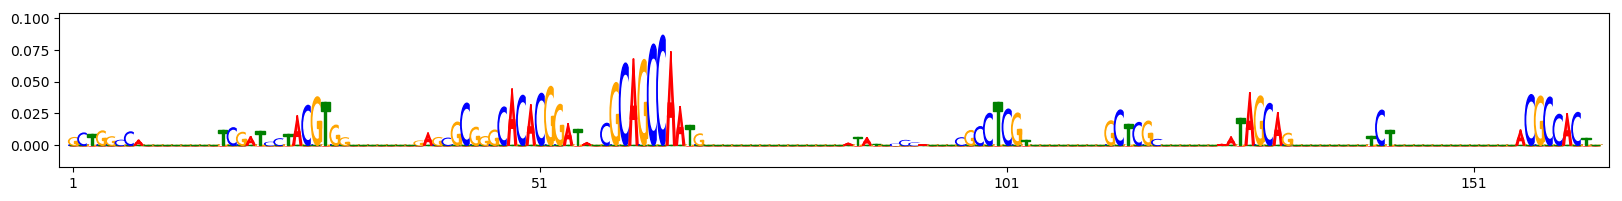

/Users/mm2842/Box/p_TFs_maize_Aug_06_2019/bok_models/C2C2-COL_ZmTF9.bagkmer.k7.1550766722.0/model/C2C2-COL_ZmTF9.bagkmer.k7.1550766722.0.4.pkl


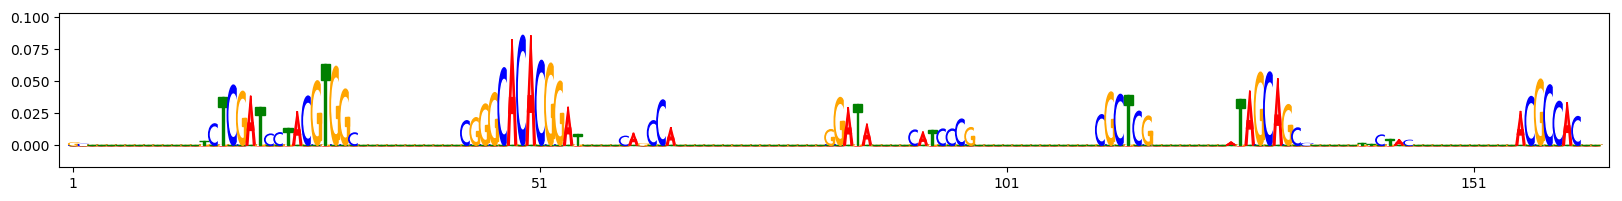

/Users/mm2842/Box/p_TFs_maize_Aug_06_2019/bok_models/C2C2-COL_ZmTF103.bagkmer.k7.1550766542.0/model/C2C2-COL_ZmTF103.bagkmer.k7.1550766542.0.4.pkl


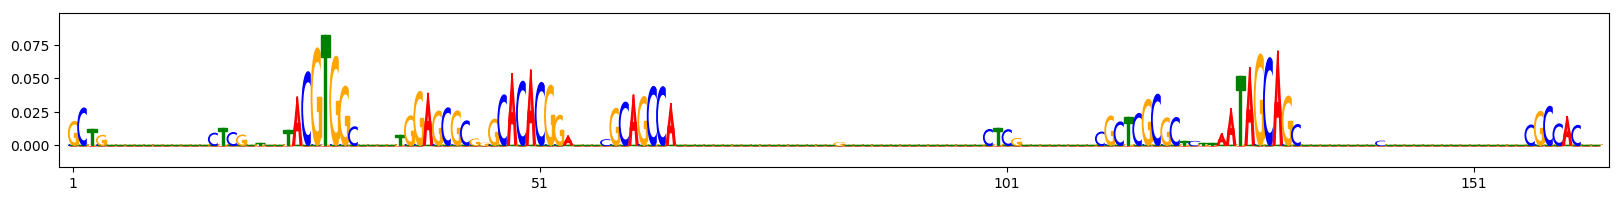

/Users/mm2842/Box/p_TFs_maize_Aug_06_2019/bok_models/MYBR_ZmTF34.bagkmer.k7.1550763962.0/model/MYBR_ZmTF34.bagkmer.k7.1550763962.0.0.pkl


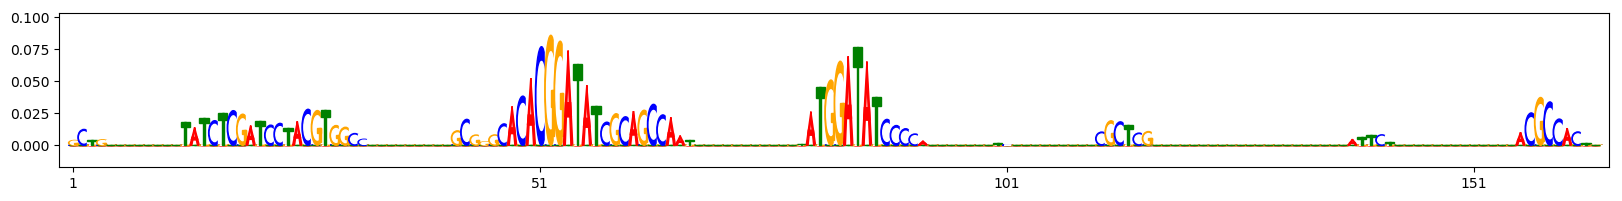

/Users/mm2842/Box/p_TFs_maize_Aug_06_2019/bok_models/MYBR_ZmTF38.bagkmer.k7.1550763980.0/model/MYBR_ZmTF38.bagkmer.k7.1550763980.0.0.pkl


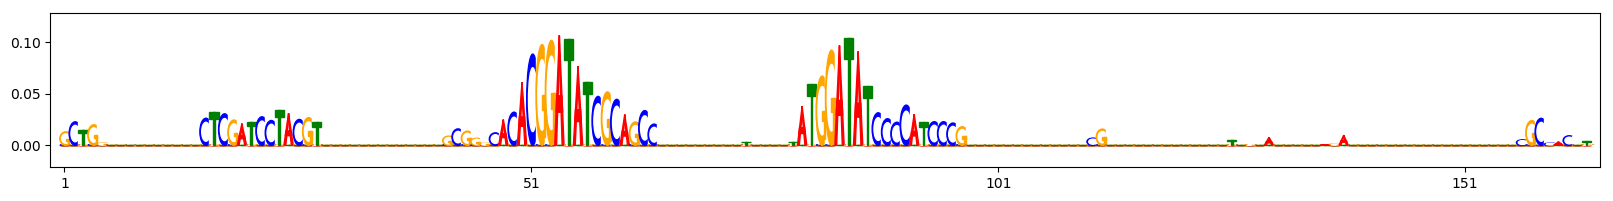

In [24]:
from sklearn.externals import joblib
logging.info(str(""))
collection = [5,172,2,9,103,34,38]#5,172,2,9,103,34,38
models_dict = {2:'/Users/mm2842/Box/p_TFs_maize_Aug_06_2019/bok_models/C2C2-COL_ZmTF2.bagkmer.k7.1550766573.0/model/C2C2-COL_ZmTF2.bagkmer.k7.1550766573.0.1.pkl',
               5:'/Users/mm2842/Box/p_TFs_maize_Aug_06_2019/bok_models/GLK_ZmTF5.bagkmer.k7.1550802193.0/model/GLK_ZmTF5.bagkmer.k7.1550802193.0.3.pkl',
               9:'/Users/mm2842/Box/p_TFs_maize_Aug_06_2019/bok_models/C2C2-COL_ZmTF9.bagkmer.k7.1550766722.0/model/C2C2-COL_ZmTF9.bagkmer.k7.1550766722.0.4.pkl',
               34:'/Users/mm2842/Box/p_TFs_maize_Aug_06_2019/bok_models/MYBR_ZmTF34.bagkmer.k7.1550763962.0/model/MYBR_ZmTF34.bagkmer.k7.1550763962.0.0.pkl',
               38:'/Users/mm2842/Box/p_TFs_maize_Aug_06_2019/bok_models/MYBR_ZmTF38.bagkmer.k7.1550763980.0/model/MYBR_ZmTF38.bagkmer.k7.1550763980.0.0.pkl',
               103:'/Users/mm2842/Box/p_TFs_maize_Aug_06_2019/bok_models/C2C2-COL_ZmTF103.bagkmer.k7.1550766542.0/model/C2C2-COL_ZmTF103.bagkmer.k7.1550766542.0.4.pkl',
               172:'/Users/mm2842/Box/p_TFs_maize_Aug_06_2019/bok_models/GLK_ZmTF172.bagkmer.k7.1550802137.0/model/GLK_ZmTF172.bagkmer.k7.1550802137.0.2.pkl'}

dir_datasets = "/Users/mm2842/Box/One-class-TF-classification/trimmed_length_sequences/"
ATAC_peaks_region = 'GCTGGCCAAAGATATCTCGATCCTACGTGGCCCAATGGAGCGCGGGCACACGGATATCGCAGCCAATGGCGGGTGGGTTATGGATATCCCCATCCCGCCTCGTCTTCGGCCGCTCGCGCTCTTAATAGCAGCCTCAGATTCTACTCGGCTCTCAAACGCCACTT'
for tf_number in collection:
    dataset_file_1 = dir_datasets + "category_1_centered_fasta/ZmTF{}_category_1_centered.fasta".format(tf_number)
    dataset_tokens_1, dummy_labels_1, dataset_idx_1 = tokenize_fasta(dataset_file_1, 1)
    dataset_file_0 = dir_datasets + "category_0_centered_fasta/ZmTF{}_category_0_centered.fasta".format(tf_number)
    dataset_tokens_0, dummy_labels_0, dataset_idx_0 = tokenize_fasta(dataset_file_0, 1)
    dataset_tokens = dataset_tokens_1 + dataset_tokens_0
    kmer_names, feature_names = build_vocabulary(dataset_tokens, stpwrds)
    idf_model = TfidfVectorizer(min_df = 1, 
                            max_df = 1.0, 
                            sublinear_tf=True,
                            use_idf=True,
                            vocabulary=kmer_names)
    extract_idf = idf_model.fit(dataset_tokens) #preserve the extract_idf to transform any other sequence again
    #extract_idf MUST be saved and used for training, and predictions and it became a constant!
    
    corpus = [ATAC_peaks_region]
    df_corpus = pd.DataFrame(corpus, index=range(len(corpus)), columns =['dna_string'])
    df_corpus["tokens"] = df_corpus["dna_string"].apply(write_ngrams)
    corpus_tokenized = df_corpus["tokens"].tolist()
    corpus_tfidf = extract_idf.transform(corpus_tokenized)
    print(models_dict.get(tf_number))
    model_file_path = models_dict.get(tf_number)
    TFIDF_LR = joblib.load(model_file_path)
    df_corpus['pred'] = TFIDF_LR.predict(corpus_tfidf) # y_pred
    df_corpus['score'] = TFIDF_LR.predict_proba(corpus_tfidf)[:,1] # y_score
    #print(tf_number, df_corpus['score'])
    
    for index, row in df_corpus.iterrows():
        input_sequence = row['dna_string']
        isc = row['score']
        fasta_seqs = [mutated_sequence(input_sequence, pos) for pos in range(len(input_sequence))]
        df_sequences = pd.DataFrame(fasta_seqs, index= range(len(input_sequence)), columns =['dna_string']) 
        df_sequences["tokens"] = df_sequences["dna_string"].apply(write_ngrams)
        occluded_tokens = df_sequences["tokens"].tolist()
        occluded_tfidf = extract_idf.transform(occluded_tokens) 
        occlusion_scores = TFIDF_LR.predict_proba(occluded_tfidf )[:,1] # y_score
        occlusion_differences = [isc - osc for osc in occlusion_scores]
        onehot_data = np.array([one_hot_encode_along_channel_axis(x, occlusion_differences) for x in [input_sequence]])
        #dna_plot_weights(onehot_data[0], subticks_frequency=50)
        save_dna_plot_weights(onehot_data[0], idx=tf_number, subticks_frequency=50)